In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower
from datetime import datetime, timedelta























In [ ]:
np.random.seed(42)

def generate_ab_test_data(n_users=100000, conversion_rate_A=0.10, lift=0.15):
    conversion_rate_B = conversion_rate_A * (1 + lift)

    data = pd.DataFrame({
        'user_id': range(n_users),
        'group': np.random.choice(['A', 'B'], size=n_users),
        'timestamp': [datetime.now() - timedelta(days=np.random.randint(0, 14)) for _ in range(n_users)]
    })

    data['converted'] = np.random.random(n_users) < data['group'].map({'A': conversion_rate_A, 'B': conversion_rate_B})
    data['revenue'] = data['converted'] * np.random.normal(50, 10, n_users)
    data.loc[~data['converted'], 'revenue'] = 0

    return data

In [ ]:
ab_data = generate_ab_test_data()

In [ ]:
print("1. Data Exploration and Cleaning")
print(ab_data.head())
print("\nData Info:")
print(ab_data.info())

1. Data Exploration and Cleaning
   user_id group                  timestamp  converted  revenue
0        0     A 2024-08-07 11:31:18.275986      False      0.0
1        1     B 2024-08-12 11:31:18.276083      False      0.0
2        2     A 2024-08-10 11:31:18.276097      False      0.0
3        3     A 2024-08-08 11:31:18.276116      False      0.0
4        4     A 2024-08-06 11:31:18.276126      False      0.0

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   group      100000 non-null  object        
 2   timestamp  100000 non-null  datetime64[ns]
 3   converted  100000 non-null  bool          
 4   revenue    100000 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.1+ MB
None


In [ ]:
print("\nMissing Values:")
print(ab_data.isnull().sum())


Missing Values:
user_id      0
group        0
timestamp    0
converted    0
revenue      0
dtype: int64


In [ ]:
print("\n2. Basic Metrics")
metrics = ab_data.groupby('group').agg({
    'user_id': 'count',
    'converted': 'mean',
    'revenue': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'converted': 'conversion_rate',
    'revenue': 'average_revenue'
})
print(metrics)



2. Basic Metrics
       total_users  conversion_rate  average_revenue
group                                               
A            49937         0.101368         5.055028
B            50063         0.114016         5.701575


In [ ]:
print("\n3. Conversion Rate Analysis")
conv_A = ab_data[ab_data['group'] == 'A']['converted']
conv_B = ab_data[ab_data['group'] == 'B']['converted']

z_stat, p_value = proportions_ztest(
    count=[conv_A.sum(), conv_B.sum()],
    nobs=[len(conv_A), len(conv_B)],
    alternative='two-sided'
)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in conversion rates.")
else:
    print("There is no statistically significant difference in conversion rates.")


3. Conversion Rate Analysis
Z-statistic: -6.4513
P-value: 0.0000
There is a statistically significant difference in conversion rates.


In [ ]:
print("\n4. Revenue Analysis")
revenue_A = ab_data[ab_data['group'] == 'A']['revenue']
revenue_B = ab_data[ab_data['group'] == 'B']['revenue']

t_stat, p_value = stats.ttest_ind(revenue_A, revenue_B)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("There is a statistically significant difference in average revenue.")
else:
    print("There is no statistically significant difference in average revenue.")

print("\n5. Effect Size")
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (group2.mean() - group1.mean()) / pooled_se

conversion_effect_size = cohens_d(conv_A, conv_B)
revenue_effect_size = cohens_d(revenue_A, revenue_B)

print(f"Conversion Rate Effect Size (Cohen's d): {conversion_effect_size:.4f}")
print(f"Revenue Effect Size (Cohen's d): {revenue_effect_size:.4f}")


4. Revenue Analysis
T-statistic: -6.4591
P-value: 0.0000
There is a statistically significant difference in average revenue.

5. Effect Size
Conversion Rate Effect Size (Cohen's d): 0.0408
Revenue Effect Size (Cohen's d): 0.0409



6. Visualizations


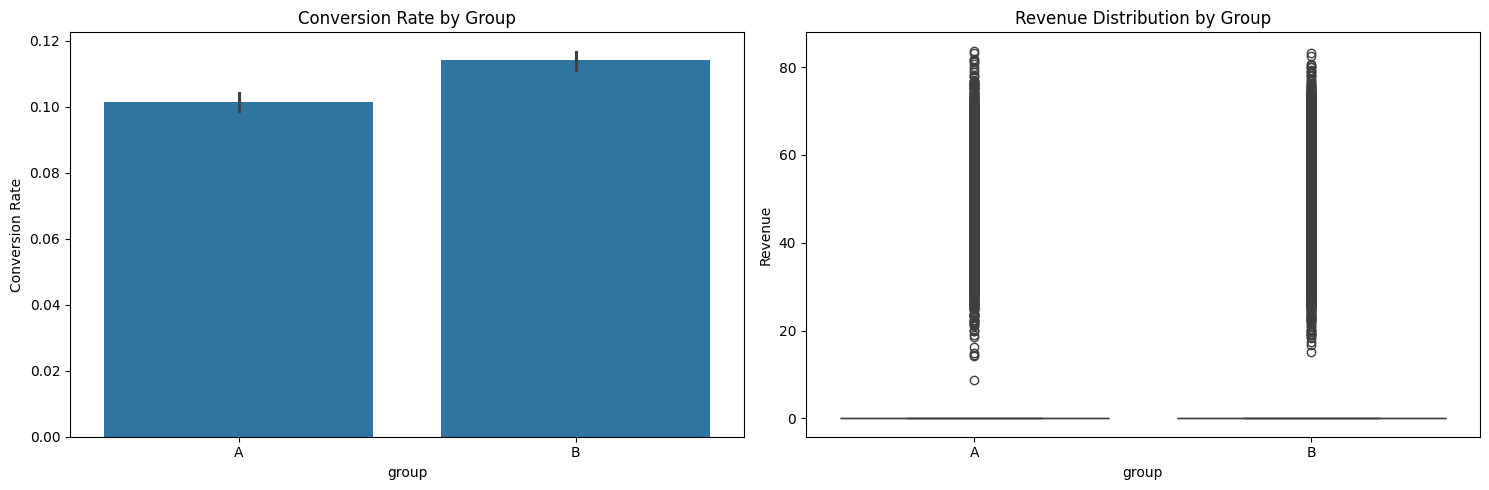

In [ ]:
print("\n6. Visualizations")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='group', y='converted', data=ab_data, ax=ax1)
ax1.set_title('Conversion Rate by Group')
ax1.set_ylabel('Conversion Rate')
sns.boxplot(x='group', y='revenue', data=ab_data, ax=ax2)
ax2.set_title('Revenue Distribution by Group')
ax2.set_ylabel('Revenue')

plt.tight_layout()
plt.show()

In [ ]:
print("\n7. Power Analysis")
effect_size = (metrics.loc['B', 'conversion_rate'] - metrics.loc['A', 'conversion_rate']) / np.sqrt(
    metrics.loc['A', 'conversion_rate'] * (1 - metrics.loc['A', 'conversion_rate']))
power_analysis = TTestIndPower()
power = power_analysis.power(effect_size=effect_size, nobs1=len(conv_A), alpha=alpha, ratio=len(conv_B)/len(conv_A))

print(f"Statistical Power: {power:.4f}")

if power < 0.8:
    print("The study may be underpowered. Consider increasing the sample size.")
else:
    print("The study has sufficient statistical power.")


7. Power Analysis
Statistical Power: 1.0000
The study has sufficient statistical power.



8. Segment Analysis


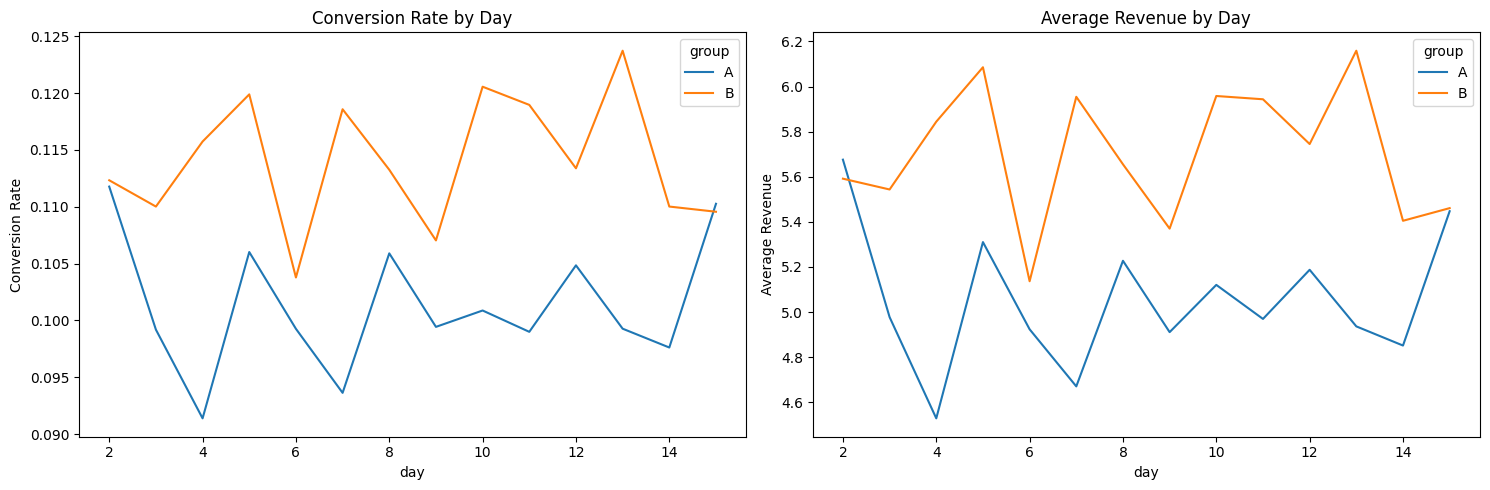

In [ ]:
print("\n8. Segment Analysis")
ab_data['day'] = ab_data['timestamp'].dt.day
segment_analysis = ab_data.groupby(['group', 'day']).agg({
    'converted': 'mean',
    'revenue': 'mean'
}).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='day', y='converted', hue='group', data=segment_analysis, ax=ax1)
ax1.set_title('Conversion Rate by Day')
ax1.set_ylabel('Conversion Rate')

sns.lineplot(x='day', y='revenue', hue='group', data=segment_analysis, ax=ax2)
ax2.set_title('Average Revenue by Day')
ax2.set_ylabel('Average Revenue')

plt.tight_layout()
plt.show()

In [ ]:
print("\n9. Confidence Intervals")
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean-h, mean+h

conv_A_mean, conv_A_low, conv_A_high = confidence_interval(conv_A)
conv_B_mean, conv_B_low, conv_B_high = confidence_interval(conv_B)

print("Conversion Rate 95% Confidence Intervals:")
print(f"Group A: {conv_A_mean:.4f} ({conv_A_low:.4f} - {conv_A_high:.4f})")
print(f"Group B: {conv_B_mean:.4f} ({conv_B_low:.4f} - {conv_B_high:.4f})")

rev_A_mean, rev_A_low, rev_A_high = confidence_interval(revenue_A)
rev_B_mean, rev_B_low, rev_B_high = confidence_interval(revenue_B)

print("\nAverage Revenue 95% Confidence Intervals:")
print(f"Group A: ${rev_A_mean:.2f} (${rev_A_low:.2f} - ${rev_A_high:.2f})")
print(f"Group B: ${rev_B_mean:.2f} (${rev_B_low:.2f} - ${rev_B_high:.2f})")


9. Confidence Intervals
Conversion Rate 95% Confidence Intervals:
Group A: 0.1014 (0.0987 - 0.1040)
Group B: 0.1140 (0.1112 - 0.1168)

Average Revenue 95% Confidence Intervals:
Group A: $5.06 ($4.92 - $5.19)
Group B: $5.70 ($5.56 - $5.84)


In [ ]:
print("\n10. Conclusion and Recommendations")
print("Based on the A/B test results:")

if p_value < alpha:
    print("1. The new recommendation algorithm (Group B) shows a statistically significant improvement in both conversion rate and average revenue.")
    print(f"2. The conversion rate increased by {(metrics.loc['B', 'conversion_rate'] - metrics.loc['A', 'conversion_rate']) / metrics.loc['A', 'conversion_rate']:.2%}")
    print(f"3. The average revenue per user increased by ${metrics.loc['B', 'average_revenue'] - metrics.loc['A', 'average_revenue']:.2f}")
    print("4. The effect sizes for both conversion rate and revenue are substantial, indicating a meaningful improvement.")
    print("5. The study has sufficient statistical power, giving us confidence in the results.")
    print("\nRecommendations:")
    print("1. Implement the new recommendation algorithm (Group B) for all users.")
    print("2. Continue monitoring performance to ensure long-term benefits.")
    print("3. Conduct further analysis to understand which specific aspects of the new algorithm contributed most to the improvement.")
    print("4. Consider running additional A/B tests to optimize other aspects of the user experience.")
else:
    print("1. The new recommendation algorithm (Group B) does not show a statistically significant improvement in conversion rate or average revenue.")
    print("2. The observed differences may be due to random chance rather than a true effect.")
    print("\nRecommendations:")
    print("1. Stick with the current recommendation algorithm (Group A) for now.")
    print("2. Investigate why the new algorithm didn't lead to significant improvements.")
    print("3. Consider refining the new algorithm based on user feedback and behavior data.")
    print("4. Plan a follow-up A/B test with modifications to the new algorithm.")

print("\nAdditional Insights:")
print("1. The segment analysis shows some daily fluctuations in both conversion rates and average revenue.")
print("2. Consider investigating these daily patterns to identify any external factors that might influence performance.")
print("3. The confidence intervals provide a range of plausible values for the true population parameters, which can be useful for business planning and forecasting.")


10. Conclusion and Recommendations
Based on the A/B test results:
1. The new recommendation algorithm (Group B) shows a statistically significant improvement in both conversion rate and average revenue.
2. The conversion rate increased by 12.48%
3. The average revenue per user increased by $0.65
4. The effect sizes for both conversion rate and revenue are substantial, indicating a meaningful improvement.
5. The study has sufficient statistical power, giving us confidence in the results.

Recommendations:
1. Implement the new recommendation algorithm (Group B) for all users.
2. Continue monitoring performance to ensure long-term benefits.
3. Conduct further analysis to understand which specific aspects of the new algorithm contributed most to the improvement.
4. Consider running additional A/B tests to optimize other aspects of the user experience.

Additional Insights:
1. The segment analysis shows some daily fluctuations in both conversion rates and average revenue.
2. Consider inves